<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/implicit_image_representation_nerf_like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png -O lena.png

--2022-06-25 12:37:25--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462.73K  1.19MB/s    in 0.4s    

2022-06-25 12:37:26 (1.19 MB/s) - ‘lena.png’ saved [473831/473831]



In [3]:
import cv2
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

%matplotlib inline

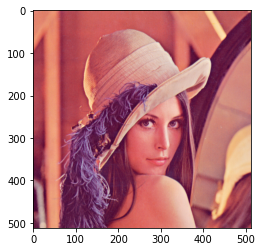

In [4]:
img = cv2.imread("lena.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = img.astype(np.float64) / 255.0
plt.imshow(img)

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(40, 256), 
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256), 
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256), 
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256), 
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3), 
    torch.nn.Sigmoid(),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)

Sequential(
  (0): Linear(in_features=40, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=3, bias=True)
  (9): Sigmoid()
)


In [14]:
L = 10

def positional_encoding(p: float, L: int):
  code = []
  for i in range(L):
    code.append(np.sin(2 ** i * np.pi * p))
    code.append(np.cos(2 ** i * np.pi * p))
  return code

positional_encoding(1, 10)

[1.2246467991473532e-16,
 -1.0,
 -2.4492935982947064e-16,
 1.0,
 -4.898587196589413e-16,
 1.0,
 -9.797174393178826e-16,
 1.0,
 -1.959434878635765e-15,
 1.0,
 -3.91886975727153e-15,
 1.0,
 -7.83773951454306e-15,
 1.0,
 -1.567547902908612e-14,
 1.0,
 -3.135095805817224e-14,
 1.0,
 -6.270191611634448e-14,
 1.0]

In [15]:

inputs = []
outputs = []

for row in range(img.shape[0]):
  for col in range(img.shape[1]):
    y = row / img.shape[0]  
    x = col / img.shape[1]
    y = 2 * y - 1
    x = 2 * x - 1
    c = img[row, col, :]
    inputs.append(positional_encoding(x, L) + positional_encoding(y, L))
    outputs.append(c)

inputs = torch.from_numpy(np.array(inputs, dtype=np.float32))
outputs = torch.from_numpy(np.array(outputs, dtype=np.float32))

print(f"inputs.shape: {inputs.shape}")
print(f"outputs.shape: {outputs.shape}")


inputs.shape: torch.Size([262144, 40])
outputs.shape: torch.Size([262144, 3])


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_d = model.to(device)
inputs_d = inputs.to(device)
outputs_d = outputs.to(device)

print(device)

cuda:0


In [17]:
zoom = 1

new_height = img.shape[0] * zoom
new_width = img.shape[1] * zoom
new_shape = [new_height, new_width, 3]

model_inputs = []
pos = []
for row in tqdm.tqdm(range(new_height)):
  for col in range(new_width):
    y = row / new_height
    x = col / new_width
    y = 2 * y - 1
    x = 2 * x - 1
    model_inputs.append(positional_encoding(x, L) + positional_encoding(y, L))
    pos.append([row, col])

model_inputs = torch.from_numpy(np.array(model_inputs, dtype=np.float32))
model_inputs = model_inputs.to(device)

100%|██████████| 512/512 [00:15<00:00, 33.35it/s]


max: 0.5154435 min: 0.4926144


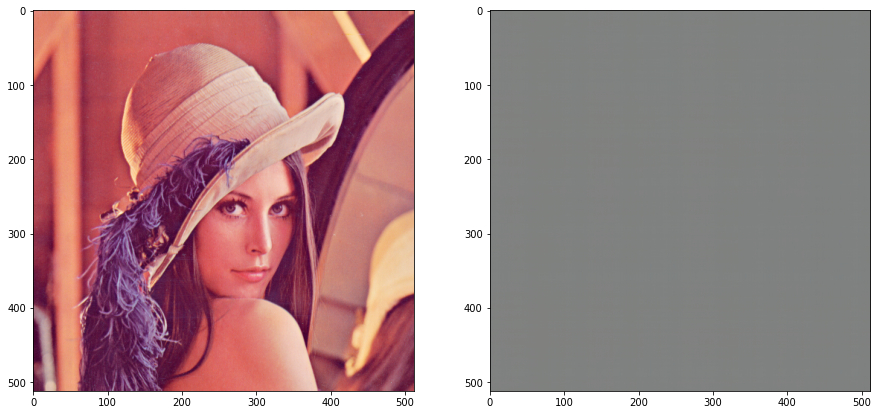

In [18]:
def predict_img(model):
  img = np.zeros(shape=new_shape, dtype=np.float32)

  model.eval()
  
  with torch.set_grad_enabled(False):
    pred = model(model_inputs)
    
  pred = pred.cpu().numpy()
  for (row, col), color in zip(pos, pred):
    img[row, col, :] = color

  return img

pred_img = predict_img(model)
print("max:", np.max(pred_img), "min:", np.min(pred_img))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(pred_img)

In [ ]:
N_EPOCHS = 10000

loss_history = []


for epoch_idx in range(N_EPOCHS):
  model_d.train()
  optimizer.zero_grad()
  preds = model_d(inputs_d)
  loss = torch.mean(torch.square(preds - outputs_d))
  loss.backward()
  optimizer.step()
  loss_history.append(loss.item())

  if epoch_idx % 500 == 0:
    #pred_img = predict_img(model)
    pred_img = preds.cpu().detach().numpy().reshape(img.shape)

    #clear_output()
    plt.figure()
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.tight_layout()
    ax[0].imshow(img)
    ax[1].imshow(pred_img)
    ax[2].plot(loss_history)
    plt.show()
    sleep(1)

    '''
    plt.figure(0, figsize=(20, 30))
    plt.subplot(1, 3, 1)
    plt.plot(loss_history)
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    '''